In [1]:
import seaborn
import matplotlib.pyplot as plt
import xarray
import tensorflow as tf
from neural_structural_optimization import problems
from neural_structural_optimization import topo_api
from neural_structural_optimization import train

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/shushu/Dropbox/python_workspace/neural-structural-optimization/neural_structural_optimization/autograd_lib.py:35: UserWarning: sksparse.cholmod not installed. Falling back to SciPy/SuperLU, but simulations will be about twice as slow.
  warnings.warn(


In [3]:
import sys
cur_file_dir = '/home/shushu/Dropbox/python_workspace/neural-structural-optimization/projects'
sys.path.insert(0,cur_file_dir)

## New Model

In [6]:
from neural_structural_optimization.models import *

In [72]:
def FlatConv3(inputs, filters):
  he_normal = tf.keras.initializers.HeNormal()
  net = layers.Conv2D(filters, 3, padding='same', kernel_initializer=he_normal)(inputs)
  net = global_normalization(net)
  return tf.nn.relu(net)

In [73]:
def UpConv4(inputs, filters):
    he_normal = tf.keras.initializers.HeNormal()
    net = layers.UpSampling2D(size=(2,2), interpolation='nearest')(inputs)
    net = layers.Conv2D(filters, 4, strides=(1, 1), padding='same', kernel_initializer=he_normal)(net)
    net = global_normalization(net)
    return tf.nn.relu(net)

In [74]:
class GANSketch(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      latent_scale=1.0,
      dense_init_scale=1.0
  ):
    super().__init__(seed, args)

    h = self.env.args['nely'] // 8
    w = self.env.args['nelx'] // 8

    net = inputs = layers.Input((latent_size,), batch_size=1)
    dense_channels = 256
    filters = h * w * dense_channels  # 256 * h/8 * w/8
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)  # 128 --> 256 * h/8 * w/8

    net = layers.Reshape([h, w, dense_channels])(net)
    net = tf.nn.relu(net)

    net = FlatConv3(net, 512)
    net = FlatConv3(net, 1024)
    net = FlatConv3(net, 1024)
    net = FlatConv3(net, 1024)
    net = FlatConv3(net, 1024)
    net = FlatConv3(net, 512)
    net = FlatConv3(net, 256)

    net = UpConv4(net, 256)  # h/4 * w/4
    net = FlatConv3(net, 256)
    net = FlatConv3(net, 128)

    net = UpConv4(net, 128)  # h/2 * w/2
    net = FlatConv3(net, 128)
    net = FlatConv3(net, 48)

    net = UpConv4(net, 48)  # h * w
    net = FlatConv3(net, 24)
    net = layers.Conv2D(1, 3, padding='same')(net)
    net = global_normalization(net)
    net = tf.nn.sigmoid(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)


In [23]:
problem = problems.mbb_beam(width=128, height=64, density=0.5)
args = topo_api.specified_task(problem)
gan1 = GANSketch(args=args)
max_iterations = 100
ds_gan1 = train.train_adam(gan1, max_iterations)

(1, 32768)
(1, 8, 16, 256)
(1, 8, 16, 256)
(1, 32, 64, 48)
(1, 64, 128, 1)
(1, 64, 128)


Text(0.5, 0, 'Optimization step')

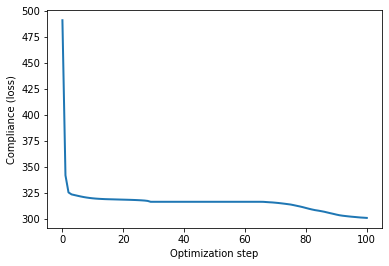

In [24]:
ds_gan1.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

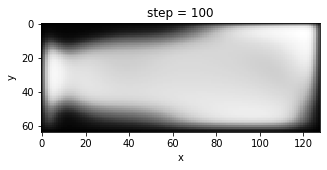

In [25]:
ds_gan1.design.sel(step=100).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [26]:
gan2 = GANSketch(args=args)
max_iterations = 100
ds_gan2 = train.train_lbfgs(gan2, max_iterations)

(1, 32768)
(1, 8, 16, 256)
(1, 8, 16, 256)
(1, 32, 64, 48)
(1, 64, 128, 1)
(1, 64, 128)


Text(0.5, 0, 'Optimization step')

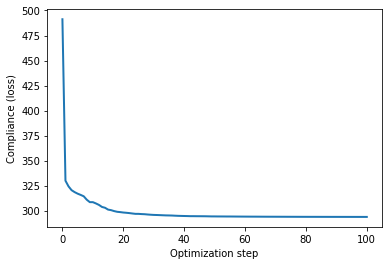

In [27]:
ds_gan2.loss.transpose().to_pandas().cummin().loc[:200].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')

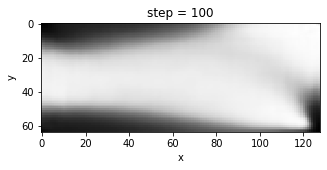

In [28]:
ds_gan2.design.sel(step=100).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

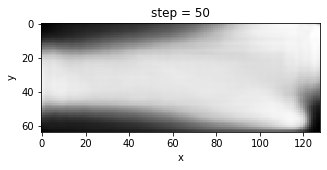

In [29]:
ds_gan2.design.sel(step=50).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

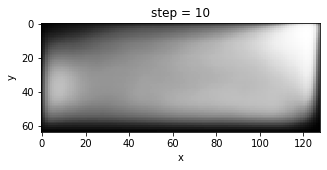

In [30]:
ds_gan2.design.sel(step=10).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

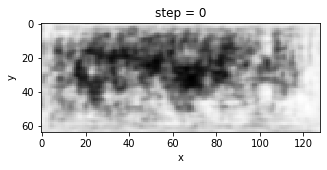

In [32]:
ds_gan2.design.sel(step=0).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [34]:
max_iterations = 100
pix = PixelModel(args=args)
ds_oc = train.optimality_criteria(pix, max_iterations)

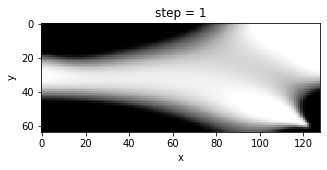

In [50]:
ds_oc.design.sel(step=1).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [75]:
problem = problems.mbb_beam(width=64, height=32, density=0.5)
args = topo_api.specified_task(problem)
gan3 = GANSketch(args=args)
max_iterations = 20
ds_gan3 = train.train_adam(gan3, max_iterations)

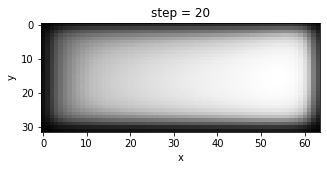

In [83]:
ds_gan3.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [84]:
ds_gan3 = train.train_lbfgs(gan3, 80)

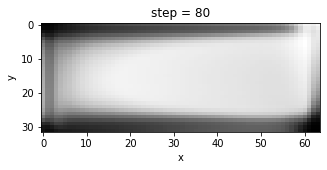

In [85]:
ds_gan3.design.sel(step=80).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [52]:
nn1 = CNNModel(args=args, resizes=(1, 1, 2, 2, 1))
ds_cnn = train.train_lbfgs(nn1, max_iterations)

(32, 64)


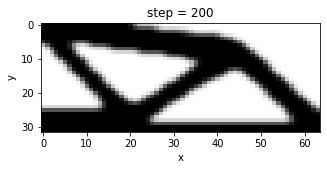

In [59]:
print(ds_cnn.design.sel(step=200).shape)

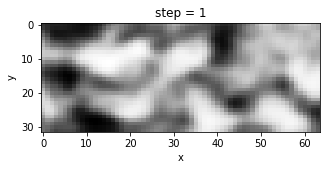

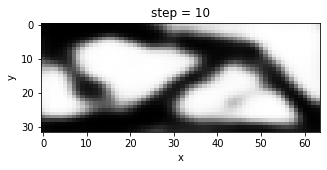

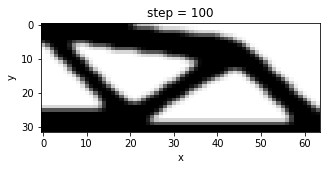

In [93]:
ds_cnn.design.sel(step=1).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
ds_cnn.design.sel(step=10).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')
ds_cnn.design.sel(step=100).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys')

In [86]:
problem = problems.mbb_beam(width=64, height=32, density=0.5)
args = topo_api.specified_task(problem)
gan4 = GANSketch(args=args)
max_iterations = 20
ds_gan4 = train.train_lbfgs(gan4, max_iterations)

lbfg的训练效果比adam好但是慢很多

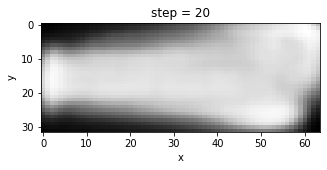

In [88]:
ds_gan4.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [89]:
ds_gan4 = train.train_lbfgs(gan4, 20)

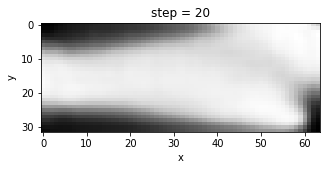

In [92]:
ds_gan4.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

## 去掉开始的卷积层

In [94]:
class GANSketch(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      latent_scale=1.0,
      dense_init_scale=1.0
  ):
    super().__init__(seed, args)

    h = self.env.args['nely'] // 8
    w = self.env.args['nelx'] // 8

    net = inputs = layers.Input((latent_size,), batch_size=1)
    dense_channels = 256
    filters = h * w * dense_channels  # 256 * h/8 * w/8
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)  # 128 --> 256 * h/8 * w/8

    net = layers.Reshape([h, w, dense_channels])(net)
    net = tf.nn.relu(net)

    net = FlatConv3(net, 256)

    net = UpConv4(net, 256)  # h/4 * w/4
    net = FlatConv3(net, 256)
    net = FlatConv3(net, 128)

    net = UpConv4(net, 128)  # h/2 * w/2
    net = FlatConv3(net, 128)
    net = FlatConv3(net, 48)

    net = UpConv4(net, 48)  # h * w
    net = FlatConv3(net, 24)
    net = layers.Conv2D(1, 3, padding='same')(net)
    net = global_normalization(net)
    net = tf.nn.sigmoid(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [95]:
problem = problems.mbb_beam(width=64, height=32, density=0.5)
args = topo_api.specified_task(problem)
gan5 = GANSketch(args=args)
max_iterations = 20
ds_gan5 = train.train_lbfgs(gan5, max_iterations)

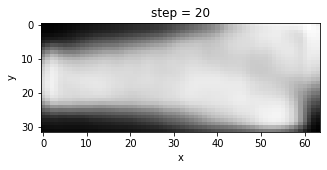

In [96]:
ds_gan5.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [97]:
ds_gan5 = train.train_lbfgs(gan5, max_iterations)

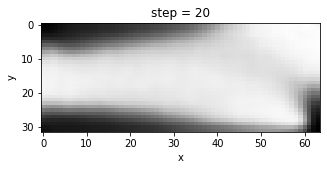

In [98]:
ds_gan5.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

#### Adam表现更差

In [99]:
gan6 = GANSketch(args=args)
max_iterations = 20
ds_gan6 = train.train_adam(gan6, max_iterations)

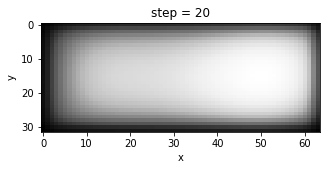

In [100]:
ds_gan6.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

### 改initializer

In [130]:
def FlatConv3(inputs, filters):
  he_normal = tf.keras.initializers.VarianceScaling()
  net = layers.Conv2D(filters, 3, padding='same', kernel_initializer=he_normal)(inputs)
  net = global_normalization(net)
  return tf.nn.relu(net)

In [131]:
def UpConv4(inputs, filters):
    he_normal = tf.keras.initializers.VarianceScaling()
    net = layers.UpSampling2D(size=(2,2), interpolation='nearest')(inputs)
    net = layers.Conv2D(filters, 4, strides=(1, 1), padding='same', kernel_initializer=he_normal)(net)
    net = global_normalization(net)
    return tf.nn.relu(net)

In [101]:
class GANSketch(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      latent_scale=1.0,
      dense_init_scale=1.0
  ):
    super().__init__(seed, args)

    h = self.env.args['nely'] // 8
    w = self.env.args['nelx'] // 8

    net = inputs = layers.Input((latent_size,), batch_size=1)
    dense_channels = 256
    filters = h * w * dense_channels  # 256 * h/8 * w/8
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)  # 128 --> 256 * h/8 * w/8

    net = layers.Reshape([h, w, dense_channels])(net)
    net = tf.nn.relu(net)

    net = FlatConv3(net, 256)

    net = UpConv4(net, 256)  # h/4 * w/4
    net = FlatConv3(net, 256)
    net = FlatConv3(net, 128)

    net = UpConv4(net, 128)  # h/2 * w/2
    net = FlatConv3(net, 128)
    net = FlatConv3(net, 48)

    net = UpConv4(net, 48)  # h * w
    net = FlatConv3(net, 24)
    net = layers.Conv2D(1, 3, padding='same')(net)
    net = global_normalization(net)
    net = tf.nn.sigmoid(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [102]:
gan7 = GANSketch(args=args)
max_iterations = 20
ds_gan7 = train.train_lbfgs(gan7, max_iterations)

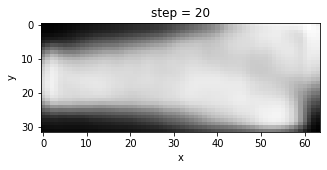

In [103]:
ds_gan7.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [102]:
gan7 = GANSketch(args=args)
max_iterations = 20
ds_gan7 = train.train_lbfgs(gan7, max_iterations)

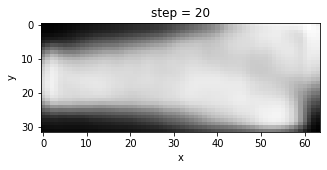

In [103]:
ds_gan7.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [116]:
gan7.core_model.trainable_variables

[<tf.Variable 'dense_15/kernel:0' shape=(128, 8192) dtype=float32, numpy=
 array([[ 0.1354723 , -0.06658554, -0.0274958 , ..., -0.07448559,
         -0.04949025,  0.0853969 ],
        [ 0.03805605, -0.02020649,  0.03211596, ..., -0.07178583,
         -0.05702316, -0.05504958],
        [-0.03473027, -0.00229131, -0.00197697, ...,  0.01061159,
         -0.09114999,  0.00341759],
        ...,
        [ 0.12700355,  0.03022366,  0.03244971, ..., -0.05377147,
          0.12356952,  0.07507943],
        [-0.05858045,  0.01607037,  0.0673888 , ..., -0.02332526,
          0.0351199 , -0.13637815],
        [-0.04488579, -0.07843148,  0.03815694, ..., -0.03054897,
         -0.08946022, -0.06628046]], dtype=float32)>,
 <tf.Variable 'dense_15/bias:0' shape=(8192,) dtype=float32, numpy=
 array([0.0000000e+00, 2.3123874e-04, 0.0000000e+00, ..., 0.0000000e+00,
        9.7505676e-05, 0.0000000e+00], dtype=float32)>,
 <tf.Variable 'conv2d_193/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
 arra

In [104]:
nn2 = CNNModel(args=args, resizes=(1, 2, 2, 2, 1))
ds_cnn2 = train.train_lbfgs(nn2, 20)

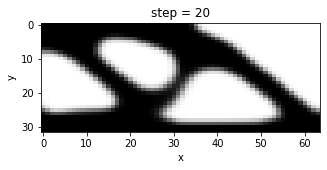

In [105]:
ds_cnn2.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

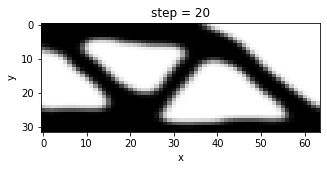

In [106]:
ds_cnn2 = train.train_lbfgs(nn2, 20)
ds_cnn2.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [109]:
ds_cnn2.loss.transpose()

<xarray.DataArray 'loss' (step: 21)>
array([9.35872184e+01, 5.52679242e+07, 5.17329666e+02, 2.12970662e+02,
       9.33810016e+01, 9.27753691e+01, 9.24267136e+01, 9.19369957e+01,
       9.14845544e+01, 9.15323082e+01, 1.79842883e+02, 9.08794643e+01,
       9.10847217e+01, 9.03429830e+01, 8.95931210e+01, 8.89689784e+01,
       8.86481619e+01, 8.84834006e+01, 8.78436202e+01, 8.75450311e+01,
       8.74133629e+01])
Coordinates:
  * step     (step) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [124]:
# ds_cnn.loss.transpose()

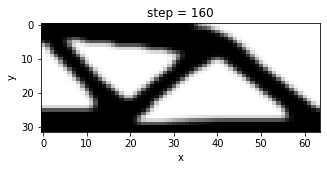

In [111]:
ds_cnn2 = train.train_lbfgs(nn2, 160)
ds_cnn2.design.sel(step=160).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 

In [114]:
ds_cnn2.loss.sel(step=160)

<xarray.DataArray 'loss' ()>
array(84.85594335)
Coordinates:
    step     int64 160

In [123]:
# nn2.core_model.trainable_variables

### GNN的weights消失
试试dropout。但是dropout一般用在全连接层，卷积层参数较少，不需要dropout。

## 更简单的GAN

In [133]:
class GANSketch(Model):

  def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      latent_scale=1.0,
      dense_init_scale=1.0
  ):
    super().__init__(seed, args)

    h = self.env.args['nely'] // 8
    w = self.env.args['nelx'] // 8

    net = inputs = layers.Input((latent_size,), batch_size=1)
    dense_channels = 128
    filters = h * w * dense_channels  # 128 * h/8 * w/8
    dense_initializer = tf.initializers.orthogonal(
        dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
    net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)  # 128 --> 128 * h/8 * w/8

    net = layers.Reshape([h, w, dense_channels])(net)
    net = tf.nn.relu(net)

    net = UpConv4(net, 128)  # h/4 * w/4
    net = FlatConv3(net, 64)

    net = UpConv4(net, 64)  # h/2 * w/2
    net = FlatConv3(net, 32)

    net = UpConv4(net, 32)  # h * w
    net = layers.Conv2D(1, 3, padding='same')(net)
    net = global_normalization(net)
    net = tf.nn.sigmoid(net)

    outputs = tf.squeeze(net, axis=[-1])

    self.core_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
    self.z = self.add_weight(
        shape=inputs.shape, initializer=latent_initializer, name='z')

  def call(self, inputs=None):
    return self.core_model(self.z)

In [134]:
gan9 = GANSketch(args=args)
ds_gan9 = train.train_lbfgs(gan9, 20)

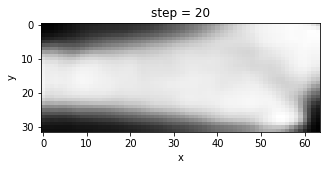

In [136]:
ds_gan9.design.sel(step=20).plot.imshow(
    x='x', y='y', size=2, aspect=2.5, col_wrap=2,
    yincrease=False, add_colorbar=False, cmap='Greys') 